<a href="https://colab.research.google.com/github/vitfrncs/LiPAI_board/blob/master/src/semana_9/ex_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semana 9 - Data augmentation

-----
4 - Crie 2 pipelines de treinamento distintas:
- Baseline: O modelo original, sem aumento de dados explícito (além da normalização).
- Básico: Usando RandomAffine (rotação, translação).
- Avançado: Usando TrivialAugmentWide combinado com RandomErasing.
- Mixup/CutMix: Implemente uma das técnicas de mistura no loop de treinamento.

Treine com o modelo da rede CNN com os pipelines escolhidos. Mantenha todos os outros hiperparâmetros (taxa de aprendizado, número de épocas, otimizador) constantes e compare os resultados:
- Acurácia final no conjunto de teste.
- Velocidade de convergência (observe as curvas de custo).

Escolhi implementar o Básico e o Avançado.

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

root_path = '/home/storopoli/Downloads'

# Pipelines distintas:

basic_trans = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

advanced_trans = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.5)
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
# definição da cnn


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU())
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instancia o Model()
model = ConvNet()

print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [ ]:
# Isto tem que retornar True
import torch
torch.cuda.is_available()

True

In [ ]:
# Sua GPU
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
# funçao que treinae e avalia
# só juntei as coisas do código antigo

def train_and_evaluate(train_transform, test_transform, label):
    # carregar datasets
    train_dataset = torchvision.datasets.MNIST(root=root_path, train=True, transform=train_transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root=root_path, train=False, transform=test_transform)

    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

    # Instanciar modelo, loss e optimizer
    model = ConvNet()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    epochs = 6

    loss_list = []
    acc_list = []

    # Treinamento
    for epoch in range(epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Acurácia do batch
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

        print(f"Epoch [{epoch+1}/{epochs}] finalizada ({label}).")

    # Avaliação no conjunto de teste
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Feed-forward com as imagens de teste
            outputs = model(images)

            # gera predições usando a função max()
            _, predicted = torch.max(outputs.data, 1)

            # Acumula total e corretas
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    test_acc = correct / total
    print(f"Acurácia do Modelo em 10k imagens de teste: {round((correct / total) * 100, 3)}")

    return loss_list, acc_list, test_acc

In [ ]:
loss_basic, acc_basic, test_basic = train_and_evaluate(basic_trans, test_trans, "BÁSICO")
loss_adv, acc_adv, test_adv = train_and_evaluate(advanced_trans, test_trans, "AVANÇADO")


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 509kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Epoch [1/6] finalizada (BÁSICO).
Epoch [2/6] finalizada (BÁSICO).
Epoch [3/6] finalizada (BÁSICO).
Epoch [4/6] finalizada (BÁSICO).
Epoch [5/6] finalizada (BÁSICO).
Epoch [6/6] finalizada (BÁSICO).
Acurácia do Modelo em 10k imagens de teste: 99.17
Epoch [1/6] finalizada (AVANÇADO).
Epoch [2/6] finalizada (AVANÇADO).
Epoch [3/6] finalizada (AVANÇADO).
Epoch [4/6] finalizada (AVANÇADO).
Epoch [5/6] finalizada (AVANÇADO).
Epoch [6/6] finalizada (AVANÇADO).
Acurácia do Modelo em 10k imagens de teste: 99.14


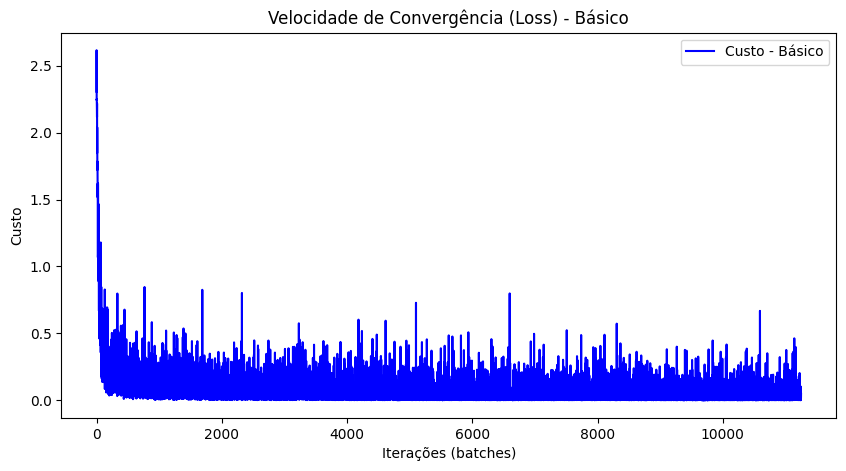

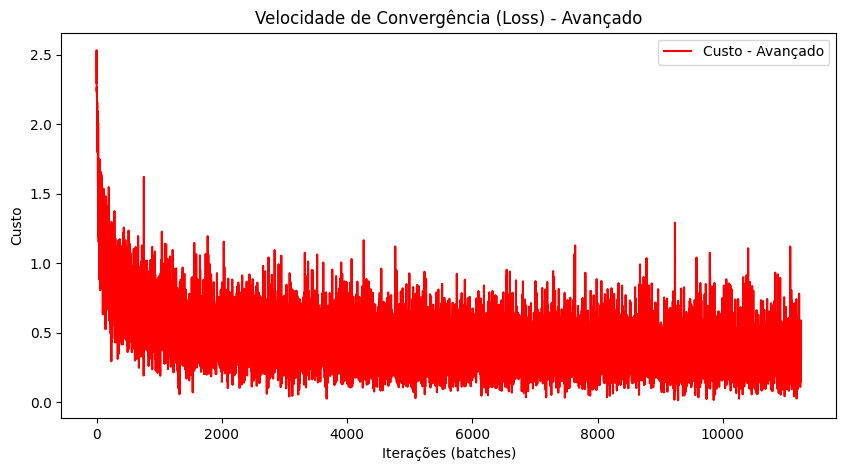

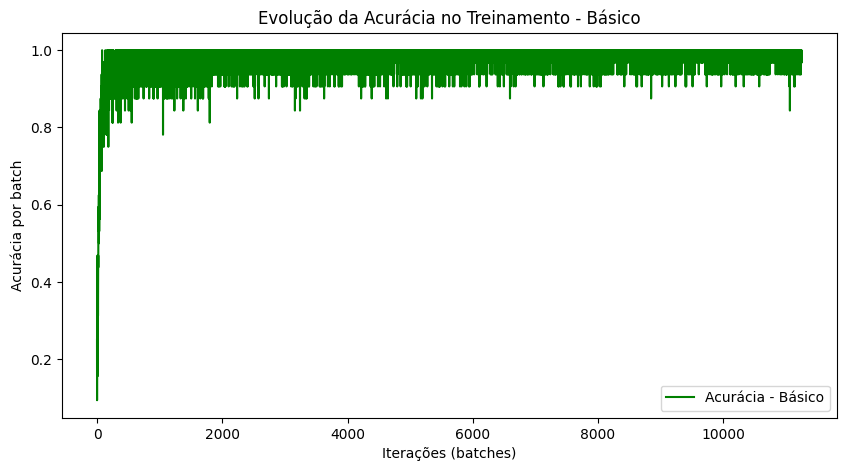

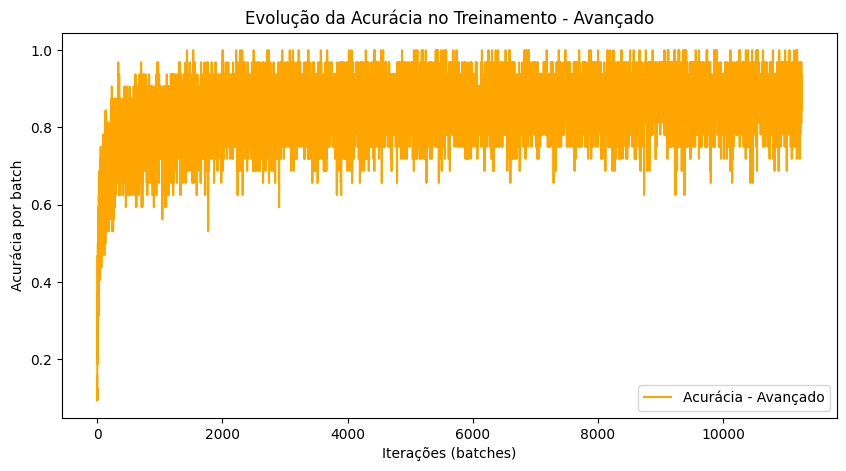

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(loss_basic, label="Custo - Básico", color="blue")
plt.xlabel("Iterações (batches)")
plt.ylabel("Custo")
plt.title("Velocidade de Convergência (Loss) - Básico")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(loss_adv, label="Custo - Avançado", color="red")
plt.xlabel("Iterações (batches)")
plt.ylabel("Custo")
plt.title("Velocidade de Convergência (Loss) - Avançado")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(acc_basic, label="Acurácia - Básico", color="green")
plt.xlabel("Iterações (batches)")
plt.ylabel("Acurácia por batch")
plt.title("Evolução da Acurácia no Treinamento - Básico")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(acc_adv, label="Acurácia - Avançado", color="orange")
plt.xlabel("Iterações (batches)")
plt.ylabel("Acurácia por batch")
plt.title("Evolução da Acurácia no Treinamento - Avançado")
plt.legend()
plt.show()
